#### Proyecto final - análisis EDA

Nota: Después de estar trabajando en este notebook para limpiar los dos datasets (de fuentes distintas como se establece en los requisitos mínimos), combinarlos y realizar un análisis preliminar de los datos con Python, me he fijado en que el archivo combinado tiene menos de 50.000 filas. 

Como ya estuve trabajando con estos datasets, pensé en añadir más filas a este mismo dataset para cumplir con las 50.000 filas, pero considero que en este caso no cambia el proceso a seguir en cuanto a la preparación del código, el análisis ni la creación del dashboard en Excel, y he preferido mantenerlo así para asegurarme de no duplicar datos que puedan afectar a las conclusiones del análisis. Espero que no suponga un problema.

A continuación el código utilizado para depurar y combinar los datasets, y realizar el análisis de datos:

In [13]:
# Proyecto Final - Análisis EDA de IA
# Limpieza, normalización y unión de datasets (INNER JOIN)
## He decidido combinar las tablas mediante un inner join para analizar únicamente los casos en los que el campo "País" ("country" y "company_location") coincide en ambos archivos.

import os
import pandas as pd
import numpy as np

DIRECTORIO_BRUTOS = "datos_brutos"
DIRECTORIO_PROCESADOS = "datos_procesados"
os.makedirs(DIRECTORIO_PROCESADOS, exist_ok=True)


# Normalización del nombre de los países para que coincidan las columnas "country" y "company_locations" de ambos datasets
MAPEO_PAISES_JOBS = {
    "United States": "United States of America",
    "US": "United States of America",
    "U.S.": "United States of America",
    "USA": "United States of America",
    "Netherlands": "The Netherlands",
    "South Korea": "Korea, Republic of",
    "Russia": "Russian Federation",
    "Czechia": "Czech Republic",
    "Vietnam": "Viet Nam",
    "Turkey": "Türkiye",
    "Iran": "Iran, Islamic Republic of",
    "Venezuela": "Venezuela, Bolivarian Republic of",
    "Bolivia": "Bolivia, Plurinational State of",
    "Hong Kong": "Hong Kong SAR",
    "Taiwan": "Taiwan, Province of China",
    "United Arab Emirates": "United Arab Emirates",
    "UAE": "United Arab Emirates",
    "Congo (Kinshasa)": "Congo, the Democratic Republic of the",
    "Congo (Brazzaville)": "Congo",
    "North Macedonia": "North Macedonia",
    "Palestine": "State of Palestine",
    "Syria": "Syrian Arab Republic",
    "Micronesia": "Micronesia, Federated States of",
    "Moldova": "Moldova, Republic of",
    "Laos": "Lao People's Democratic Republic",
}

def normalizar_pais_indice(nombre):
    if pd.isna(nombre):
        return np.nan
    return str(nombre).strip()

def normalizar_pais_empleos(nombre):
    if pd.isna(nombre):
        return np.nan
    nombre = str(nombre).strip()
    return MAPEO_PAISES_JOBS.get(nombre, nombre)


# Guardar CSV
def guardar_csv(dataframe, nombre_archivo):
    ruta = os.path.join(DIRECTORIO_PROCESADOS, nombre_archivo)
    dataframe.to_csv(ruta, index=False, encoding="utf-8")
    print(f"Archivo guardado: {ruta}")


# Limpieza del dataset "AI Global Index" -> genera "ai_global_index_limpio.csv"
def limpiar_dataset_indice():
    ruta = os.path.join(DIRECTORIO_BRUTOS, "ai_global_index_db.csv")
    datos_indice = pd.read_csv(ruta, low_memory=False)

    datos_indice.columns = [c.strip().lower().replace(" ", "_") for c in datos_indice.columns]

    if "country" not in datos_indice.columns:
        raise ValueError("No se encontró la columna 'Country' en ai_global_index_db.csv")

    datos_indice["pais_normalizado"] = datos_indice["country"].map(normalizar_pais_indice)

    columnas_no_numericas = {"country", "pais_normalizado", "region", "cluster", "income_group", "political_regime"}
    for c in datos_indice.columns:
        if c not in columnas_no_numericas:
            datos_indice[c] = pd.to_numeric(datos_indice[c], errors="ignore")

    datos_indice = datos_indice.drop_duplicates()

    guardar_csv(datos_indice, "ai_global_index_limpio.csv")
    return datos_indice


# Limpieza del dataset "AI Job Market" -> genera "ai_job_dataset_limpio.csv"
def limpiar_dataset_empleos():
    ruta = os.path.join(DIRECTORIO_BRUTOS, "ai_job_dataset.csv")
    datos_empleos = pd.read_csv(ruta, low_memory=False)

    datos_empleos.columns = [c.strip().lower().replace(" ", "_") for c in datos_empleos.columns]

    if "company_location" not in datos_empleos.columns:
        raise ValueError("No se encontró la columna 'company_location' en ai_job_dataset.csv")
    datos_empleos["pais_normalizado"] = datos_empleos["company_location"].map(normalizar_pais_empleos)

    if "salary_usd" in datos_empleos.columns:
        datos_empleos["salario_usd"] = pd.to_numeric(datos_empleos["salary_usd"], errors="coerce")

    if "posting_date" in datos_empleos.columns:
        datos_empleos["fecha_publicacion"] = pd.to_datetime(datos_empleos["posting_date"], errors="coerce")
        datos_empleos["anio"] = datos_empleos["fecha_publicacion"].dt.year

    for c in ["experience_level", "employment_type", "company_size", "industry", "education_required"]:
        if c in datos_empleos.columns:
            datos_empleos[c] = datos_empleos[c].astype("category")

    datos_empleos = datos_empleos.drop_duplicates()

    guardar_csv(datos_empleos, "ai_job_dataset_limpio.csv")
    return datos_empleos


# Unión de datasets (INNER JOIN) -> genera "ai_merged_limpio.csv" (también genera un reporte de países sin match)
def unir_datasets(datos_indice, datos_empleos):
    columnas_indice = [
        "pais_normalizado", "talent", "infrastructure", "operating_environment",
        "research", "development", "government_strategy", "commercial", "total_score",
        "region", "cluster", "income_group", "political_regime"
    ]
    columnas_existentes = [c for c in columnas_indice if c in datos_indice.columns]
    indice_reducido = datos_indice[columnas_existentes].copy()

    # INNER JOIN (dataset final para análisis)
    datos_comunes = datos_empleos.merge(
        indice_reducido, on="pais_normalizado", how="inner", validate="m:1"
    )
    guardar_csv(datos_comunes, "ai_merged_limpio.csv")
    print(f"Unión completada con INNER JOIN")
    print(f"Filas finales (registros comunes): {len(datos_comunes):,} | Columnas: {len(datos_comunes.columns)}")
    print(f"Países incluidos (comunes): {datos_comunes['pais_normalizado'].nunique()}")

    # LEFT JOIN "auxiliar" (solo para detectar países sin match)
    left_aux = datos_empleos.merge(
        indice_reducido, on="pais_normalizado", how="left", validate="m:1"
    )
    paises_sin_match = left_aux.loc[left_aux["total_score"].isna(), "pais_normalizado"].dropna().unique()
    df_reporte = pd.DataFrame({"pais_sin_coincidencia": sorted(paises_sin_match)})
    guardar_csv(df_reporte, "paises_sin_coincidencia.csv")
    print(f"📄 Países sin coincidencia (presentes en empleos pero ausentes en índice): {len(paises_sin_match)}")

    return datos_comunes


# EDA básico (sobre el dataset INNER JOIN) -> genera "correlaciones_previas.csv"
def eda_basico(datos):
    print("Top 10 países por salario medio (USD):")
    if "salario_usd" in datos.columns:
        print(
            datos.groupby("pais_normalizado")["salario_usd"]
            .mean().sort_values(ascending=False)
            .head(10).round(0)
        )

    print("Correlación entre métricas del índice y salario:")
    columnas_correlacion = [
        "salario_usd", "talent", "infrastructure", "operating_environment", "research",
        "development", "government_strategy", "commercial", "total_score"
    ]
    columnas_correlacion = [c for c in columnas_correlacion if c in datos.columns]
    corr = datos[columnas_correlacion].corr(numeric_only=True).round(3)
    guardar_csv(corr.reset_index(), "correlaciones_previas.csv")
    print(corr)


def main():
    print("Iniciando pipeline de limpieza, unión (INNER) y análisis...")
    datos_indice = limpiar_dataset_indice()
    datos_empleos = limpiar_dataset_empleos()
    datos_comunes = unir_datasets(datos_indice, datos_empleos)
    eda_basico(datos_comunes)
    print("Proceso completado. Archivos guardados en 'datos_procesados/'.")

if __name__ == "__main__":
    main()


Iniciando pipeline de limpieza, unión (INNER) y análisis...


FileNotFoundError: [Errno 2] No such file or directory: 'datos_brutos/ai_global_index_db.csv'

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Cargo el archivo "merged" para trabajar con los dos datasets combinados
ruta_combinado = "../datos_procesados/ai_merged_limpio.csv"
df = pd.read_csv(ruta_combinado)

# 2. Limpieza antes del EDA

## Elimina las celdas con salario no válido
df = df[pd.to_numeric(df["salario_usd"], errors="coerce").notna()].copy()
df["salario_usd"] = df["salario_usd"].astype(float)

## 2.1. Crea una versión de país con un nombre “corto” para los gráficos
mapa_pais_corto = {
    "United States of America": "United States",
    "The Netherlands": "Netherlands",
    "Korea, Republic of": "South Korea",
    "Russian Federation": "Russia",
    "Viet Nam": "Vietnam",
    "Türkiye": "Turkey",
    "Iran, Islamic Republic of": "Iran",
    "Hong Kong SAR": "Hong Kong",
    "Taiwan, Province of China": "Taiwan",
    "Congo, the Democratic Republic of the": "DR Congo",
    "Bolivia, Plurinational State of": "Bolivia",
    "Venezuela, Bolivarian Republic of": "Venezuela",
}
df["pais_mostrar"] = df["pais_normalizado"].replace(mapa_pais_corto)

# 2.2. Función de helper para títulos
def titulo(s):
    plt.title(s, fontsize=14)
    plt.xlabel("")
    plt.ylabel("")

# 2.3. Resumen de nulos
(df.isna().mean()*100).sort_values(ascending=False).head(15)

job_id                   0.0
job_title                0.0
salario_usd              0.0
fecha_publicacion        0.0
anio                     0.0
talent                   0.0
infrastructure           0.0
operating_environment    0.0
research                 0.0
development              0.0
government_strategy      0.0
commercial               0.0
total_score              0.0
region                   0.0
cluster                  0.0
dtype: float64

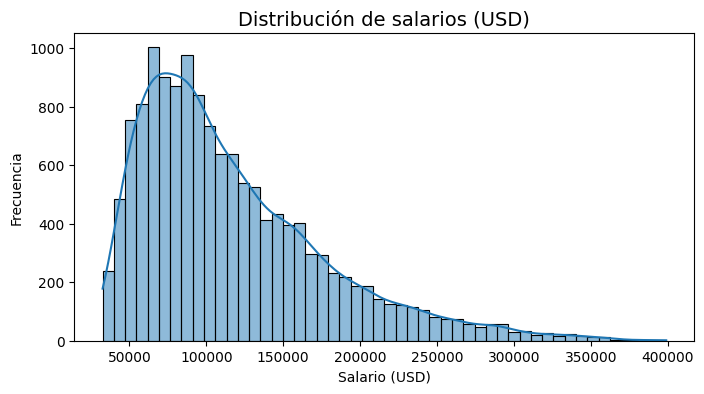

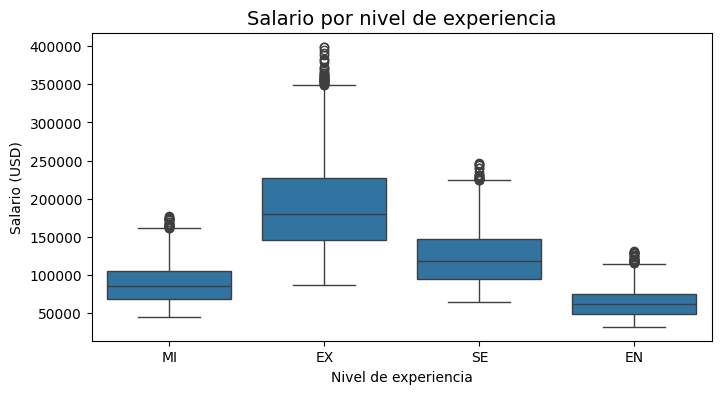

count      mean    median
pais_mostrar                             
Switzerland       746  170639.0  152901.0
Denmark           778  165652.0  147504.0
Norway            721  159491.0  142386.0
United States     724  146833.0  128606.0
United Kingdom    729  128720.0  115281.0
Singapore         764  128004.0  115122.0
Netherlands       731  126750.0  112202.0
Sweden            752  123560.0  109435.0
Germany           814  121810.0  106923.0
Australia         732  118239.0  103206.0
France            769  114411.0  101908.0
Canada            769  114253.0  100392.0
Finland           733   88726.0   80143.0
Israel            751   86990.0   78614.0
Japan             733   86861.0   79484.0
Ireland           750   86061.0   73940.0
Austria           765   85175.0   74005.0
China             763   84899.0   76543.0
India             754   84236.0   76035.0

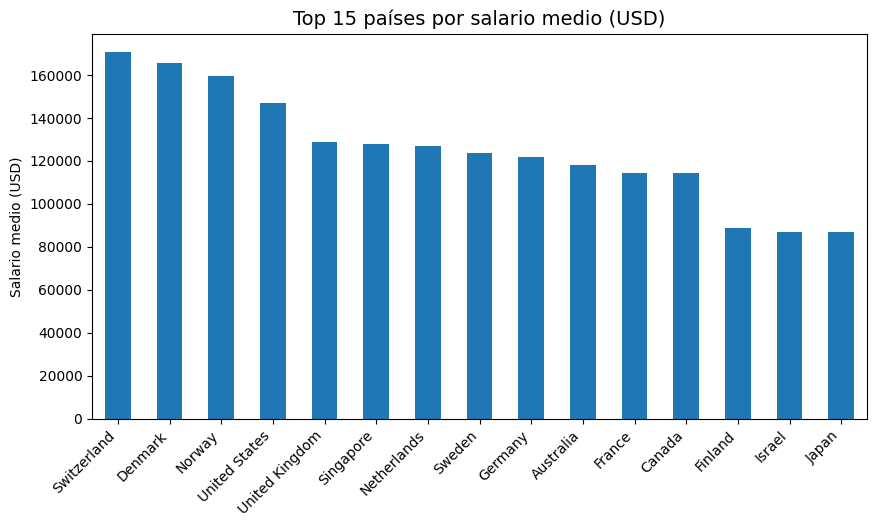

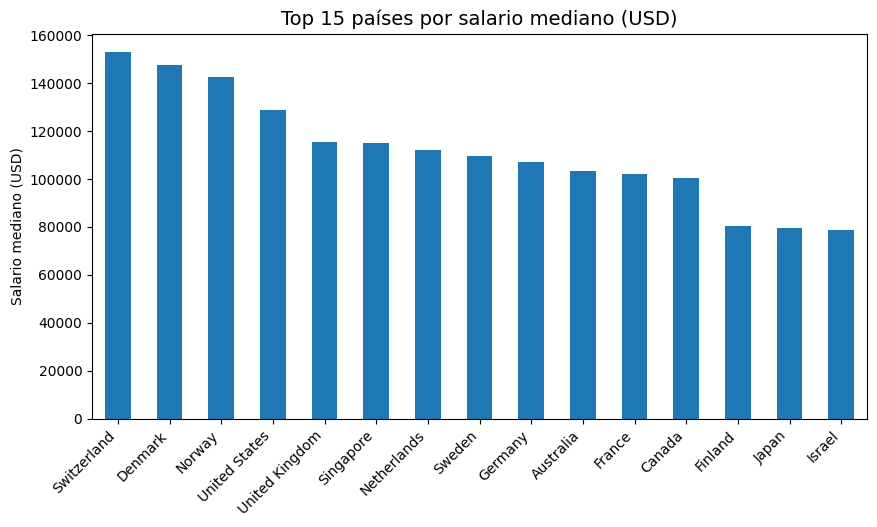

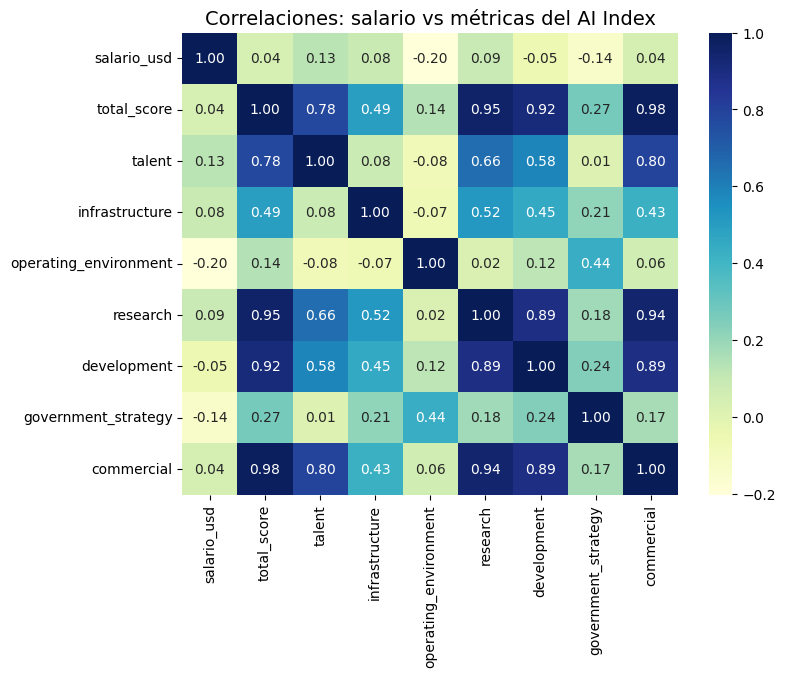

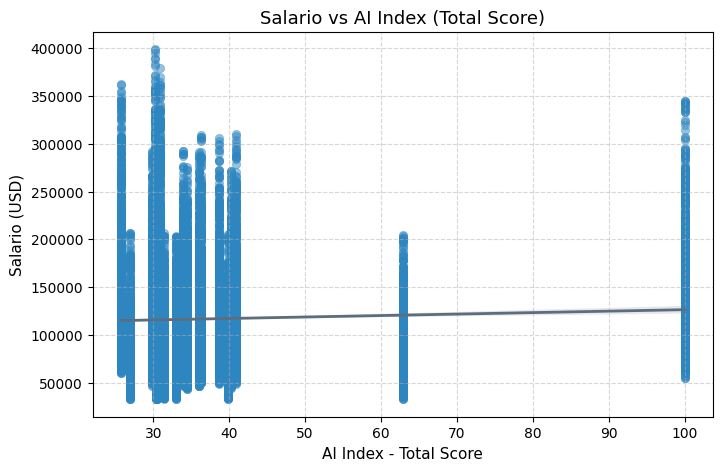

talent                   0.125983
research                 0.088587
infrastructure           0.084578
commercial               0.041710
total_score              0.041110
development             -0.053079
government_strategy     -0.141083
operating_environment   -0.202829
Name: salario_usd, dtype: float64

La métrica con mayor correlación con el salario es: 'talent' (corr=0.13).


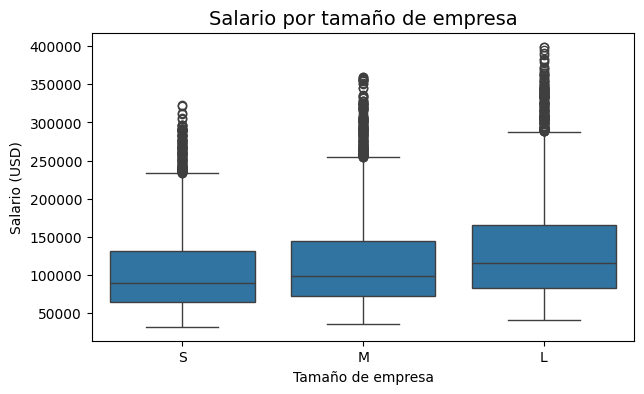

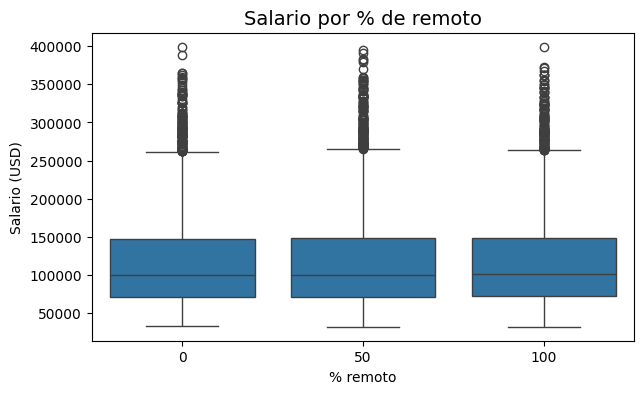

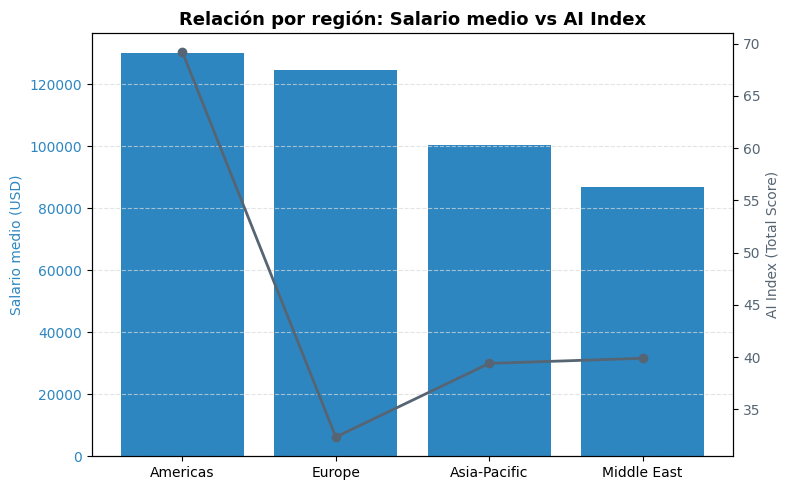

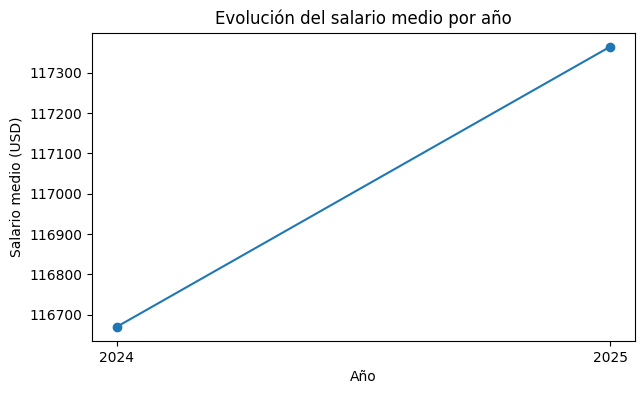

In [24]:
import seaborn as sns

# 3. EDA y creación de gráficos

# 3.1. Distribuciones y valores atípicos de salario
# Histograma
plt.figure(figsize=(8,4))
sns.histplot(df["salario_usd"], bins=50, kde=True)
titulo("Distribución de salarios (USD)")
plt.xlabel("Salario (USD)")
plt.ylabel("Frecuencia")
plt.show()

# Boxplot por nivel de experiencia
if "experience_level" in df.columns:
    plt.figure(figsize=(8,4))
    sns.boxplot(data=df, x="experience_level", y="salario_usd", order=df["experience_level"].value_counts().index)
    titulo("Salario por nivel de experiencia")
    plt.xlabel("Nivel de experiencia")
    plt.ylabel("Salario (USD)")
    plt.show()

# Top países por salario medio y por mediana
agr = df.groupby("pais_mostrar")["salario_usd"].agg(["count","mean","median"]).sort_values("mean", ascending=False)
display(agr.head(20).round(0))

top = agr.head(15)

plt.figure(figsize=(10,5))
top["mean"].plot(kind="bar")
titulo("Top 15 países por salario medio (USD)")
plt.ylabel("Salario medio (USD)")
plt.xticks(rotation=45, ha="right")
plt.show()

plt.figure(figsize=(10,5))
top.sort_values("median", ascending=False)["median"].plot(kind="bar")
titulo("Top 15 países por salario mediano (USD)")
plt.ylabel("Salario mediano (USD)")
plt.xticks(rotation=45, ha="right")
plt.show()

# Correlaciones entre salario y métricas del dataset AI Global Index
cols_idx = [c for c in ["salario_usd","total_score","talent","infrastructure","operating_environment",
                        "research","development","government_strategy","commercial"] if c in df.columns]
corr = df[cols_idx].corr(numeric_only=True)

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="YlGnBu", fmt=".2f")
titulo("Correlaciones: salario vs métricas del AI Index")
plt.show()

corr["salario_usd"].sort_values(ascending=False)

# Relación salario vs nivel de desarrollo (total score)
import numpy as np
plt.figure(figsize=(8,5))
sns.scatterplot(
    data=df,
    x="total_score", 
    y="salario_usd",
    alpha=0.5,
    color="#2E86C1",
    edgecolor=None
)
sns.regplot(
    data=df,
    x="total_score",
    y="salario_usd",
    scatter=False,
    color="#5D6D7E",
    line_kws={"lw":2}
)
plt.title("Salario vs AI Index (Total Score)", fontsize=13)
plt.xlabel("AI Index - Total Score", fontsize=11)
plt.ylabel("Salario (USD)", fontsize=11)
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

# Correlaciones AI Index con las diferentes variables (¿qué metrica del Index "explica" mejor el salario?)
import numpy as np
ranking_corr = corr["salario_usd"].drop("salario_usd").sort_values(ascending=False)
display(ranking_corr)
# Conclusión
mejor = ranking_corr.index[0]
print(f"La métrica con mayor correlación con el salario es: '{mejor}' (corr={ranking_corr.iloc[0]:.2f}).")

# Salario por tamaño de empresa, tipo de empleo y remoto
if "company_size" in df.columns:
    plt.figure(figsize=(7,4))
    sns.boxplot(data=df, x="company_size", y="salario_usd", order=df["company_size"].value_counts().index)
    titulo("Salario por tamaño de empresa")
    plt.xlabel("Tamaño de empresa")
    plt.ylabel("Salario (USD)")
    plt.show()

if "employment_type" in df.columns:
    plt.figure(figsize=(7,4))
    sns.boxplot(data=df, x="employment_type", y="salario_usd", order=df["employment_type"].value_counts().index)
    titulo("Salario por tipo de contrato")
    plt.xlabel("Tipo de empleo")
    plt.ylabel("Salario (USD)")
    plt.show()

if "remote_ratio" in df.columns:
    plt.figure(figsize=(7,4))
    sns.boxplot(data=df, x="remote_ratio", y="salario_usd", order=sorted(df["remote_ratio"].dropna().unique()))
    titulo("Salario por % de remoto")
    plt.xlabel("% remoto")
    plt.ylabel("Salario (USD)")
    plt.show()

# Vista por región: salarios y desarrollo (añado doble eje al gráfico porque la barra de "total_score no se veía al utilizar el mismo eje que la variable "salario")

colores = {
    "azul_principal": "#2E86C1",   
    "azul_suave": "#5DADE2",        
    "gris_oscuro": "#566573",        
    "gris_claro": "#D5DBDB"        
}

reg = df.groupby("region")[["salario_usd", "total_score"]].mean().sort_values("salario_usd", ascending=False)

fig, ax1 = plt.subplots(figsize=(8,5))
fig.patch.set_facecolor("white")  

# Eje 1: salario
ax1.bar(reg.index, reg["salario_usd"], color=colores["azul_principal"], label="Salario medio (USD)")
ax1.set_ylabel("Salario medio (USD)", color=colores["azul_principal"])
ax1.tick_params(axis='y', labelcolor=colores["azul_principal"])
ax1.grid(axis='y', linestyle="--", color=colores["gris_claro"], alpha=0.7)

# Eje 2: AI Index
ax2 = ax1.twinx()
ax2.plot(reg.index, reg["total_score"], color=colores["gris_oscuro"], marker="o", linewidth=2, label="AI Index (Total Score)")
ax2.set_ylabel("AI Index (Total Score)", color=colores["gris_oscuro"])
ax2.tick_params(axis='y', labelcolor=colores["gris_oscuro"])

plt.title("Relación por región: Salario medio vs AI Index", fontsize=13, fontweight="bold")
plt.xticks(rotation=25, ha="right")
plt.tight_layout()
plt.show()

# Tendencia temporal - variable "anio" (añado este gráfico aunque no es muy informativo ya que solo aparecen dos años)
df["anio"] = pd.to_numeric(df["anio"], errors="coerce").astype("Int64")

ts = (df.dropna(subset=["anio"])
        .assign(anio=lambda d: d["anio"].astype(int))
        .groupby("anio")["salario_usd"].mean())

fig, ax = plt.subplots(figsize=(7,4))
ax.plot(ts.index.values, ts.values, marker="o")
ax.set_title("Evolución del salario medio por año")
ax.set_xlabel("Año")
ax.set_ylabel("Salario medio (USD)")
ax.set_xticks(ts.index.values)      
plt.show()

In [26]:
conclusiones = []

import pandas as pd

conclusiones = []

col_pais = "pais_mostrar" if "pais_mostrar" in df.columns else "pais_normalizado"

# 1) Correlación principal salario vs AI Index
cols_corr_posibles = [
    "salario_usd", "total_score", "talent", "infrastructure",
    "operating_environment", "research", "development",
    "government_strategy", "commercial"
]
cols_corr = [c for c in cols_corr_posibles if c in df.columns]
corr = df[cols_corr].corr(numeric_only=True)

if "salario_usd" in corr.columns and corr.shape[0] > 1:
    ranking_corr = corr["salario_usd"].drop("salario_usd", errors="ignore").sort_values(ascending=False)
    if len(ranking_corr) > 0:
        mejor = ranking_corr.index[0]
        conclusiones.append(
            f"La métrica del AI Index más asociada al salario es '{mejor}' "
            f"(corr={ranking_corr.iloc[0]:.2f})."
        )
    else:
        conclusiones.append("No se pudo calcular un ranking de correlaciones (faltan métricas numéricas).")
else:
    conclusiones.append("No hay suficientes columnas numéricas para calcular correlaciones con el salario.")

# 2) País top y brecha
if col_pais in df.columns and "salario_usd" in df.columns:
    top_paises = (
        df.groupby(col_pais)["salario_usd"]
          .agg(mean="mean", median="median", count="count")
          .sort_values("mean", ascending=False)
    )
    paises_val = top_paises.reset_index()
    if len(paises_val) >= 2:
        gap = paises_val.loc[0, "mean"] - paises_val.loc[1, "mean"]
        conclusiones.append(
            f"El país con mayor salario medio es {paises_val.loc[0, col_pais]} "
            f"({paises_val.loc[0, 'mean']:.0f} USD), con una brecha de {gap:.0f} USD respecto al siguiente."
        )
    elif len(paises_val) == 1:
        conclusiones.append(
            f"El país con mayor salario medio es {paises_val.loc[0, col_pais]} "
            f"({paises_val.loc[0, 'mean']:.0f} USD)."
        )

# 3) Experiencia
if "experience_level" in df.columns and "salario_usd" in df.columns:
    exp_med = (
        df.groupby("experience_level")["salario_usd"]
          .median().sort_values(ascending=False)
    )
    if len(exp_med) > 0:
        conclusiones.append(
            f"Por nivel de experiencia, la mediana salarial más alta es {exp_med.index[0]} "
            f"({exp_med.iloc[0]:.0f} USD)."
        )

# 4) Región
if "region" in df.columns and "salario_usd" in df.columns:
    reg_med = (
        df.groupby("region")["salario_usd"]
          .mean().sort_values(ascending=False)
    )
    if len(reg_med) > 0:
        conclusiones.append(
            f"Por región, destaca {reg_med.index[0]} con salario medio de {reg_med.iloc[0]:.0f} USD."
        )

# 5) Resumen final
print("Conclusiones globales:")
for i, c in enumerate(conclusiones, 1):
    print(f"{i}. {c}")


Conclusiones globales:
1. La métrica del AI Index más asociada al salario es 'talent' (corr=0.13).
2. El país con mayor salario medio es Switzerland (170639 USD), con una brecha de 4987 USD respecto al siguiente.
3. Por nivel de experiencia, la mediana salarial más alta es EX (179894 USD).
4. Por región, destaca Americas con salario medio de 130052 USD.
